# Stochastic Variational Sparse Gaussian Process Classification (白色化なし)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

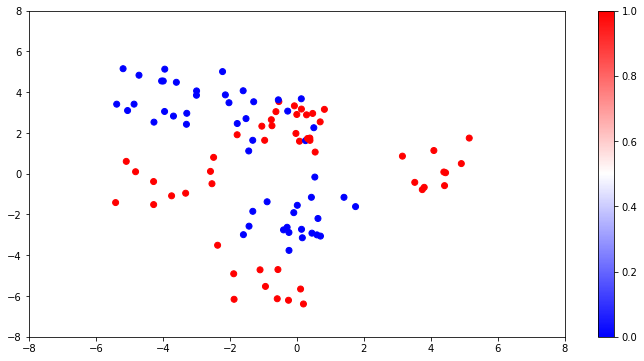

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = False)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    for batch_X, batch_y in dataloader:
        loss = svi.step(batch_X, batch_y, num_data = X.shape[0])
    if epoch % (n_epochs / 10) == 0:
        print(loss)

127.88525121227639
34.97629713105151
41.876447428948715
54.72997761373916
43.030796181314315
56.44602331407902
38.68731190741305
56.234065592321734
42.29597722151805
54.969710980302224


---

## 推論結果

### 予測分布

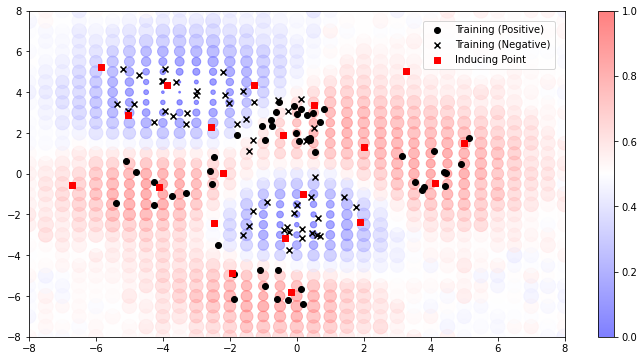

CPU times: user 23.8 s, sys: 1.19 s, total: 25 s
Wall time: 6.84 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7175, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-0.3995,  1.9197],
        [-5.8347,  5.2445],
        [ 4.9845,  1.5270],
        [-2.2059,  0.0410],
        [-4.1148, -0.6598],
        [-5.0478,  2.8904],
        [-1.9392, -4.8793],
        [ 0.1860, -1.0185],
        [ 0.5289,  3.3907],
        [-2.4844, -2.3976],
        [ 3.2550,  5.0530],
        [-3.8802,  4.3696],
        [ 4.1281, -0.4405],
        [-1.2794,  4.3540],
        [-6.7239, -0.5451],
        [-2.5481,  2.3104],
        [-0.1740, -5.8229],
        [ 1.8921, -2.3611],
        [ 1.9971,  1.2917],
        [-0.3621, -3.1429]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.7770, -1.0494,  1.1735,  0.6281,  1.5646, -1.4211,  0.9826, -1.6451,
          0.8952,  0.0314,  0.2378, -2.3539,  1.5691, -0.9998,  0.5601, -1.0202,
          1.3696, -1.1666,  1.1134, -1.7600]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 3.2924e-01,  4.4353e-02, -3.1902e-02,  1.2685e-01, -4.7734e-02,
           1.2803e-02,  2.0414e-02,  9.6681e-02,  8.5939e-02, -1.2813e-02,
           2.1224e-02, -7.9437e-03,  1.9959e-02, -2.5060e-02,  7.8986e-03,
           2.2483e-02, -2.5227e-02,  3.0008e-02,  8.7706e-02,  8.3870e-03],
         [ 4.4353e-02,  5.9371e-01,  1.0150e-01,  2.0228e-02, -1.6212e-02,
           1.3227e-01, -3.2204e-02,  8.1960e-02,  6.8184e-02,  5.5770e-02,
           5.3358e-02, -2.7138e-03, -2.9924e-02,  6.4202e-03,  5.3418e-02,
          -4.7042e-02,  5.2659e-02, -5.3241e-02,  2.2189e-02,  1.0792e-01],
         [-3.1902e-02,  1.0150e-01,  7.9241e-01, -1.2176e-02,  1.1296e-01,
          -1.5505e-02,  1.9264e-02,  1.2960e-01,  2.4058e-03,  3.5562e-02,
           7.2829e-02,  9.5450e-03,  2.1029e-01,  7.2468e-02,  9.4188e-02,
          -6.6795e-03,  4.7530e-02,  1.1455e-01,  1.1908e-01,  1.2755e-02],
         [ 1.2685e-01,  2.0228e-02, -1.2176e-02,  4.4747e-01,  1.1231e-01,
           6.8844e-02,